# calculating implied volatility for FX options

# Import

In [293]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import exp, sqrt, log
from scipy.stats import norm
from datetime import datetime

# Defining Garman Kohlhagen model

In [294]:
#defining Garman Kohlhagen currency options pricing model

class GarmanKolhagen:

    def __init__(
        self, asset_price, strike, tenor,
        rate_local, rate_foreign, volatility, option_type):
        self.asset_price = asset_price
        self.strike = strike
        self.rate_local = rate_local
        self.rate_foreign = rate_foreign
        self.volatility = volatility
        self.option_type = option_type
        self.price = self.garman_kohlhagen_price(asset_price, strike, tenor, 
                               rate_local, rate_foreign, 
                               volatility, option_type)
        self.vega = self.vega(asset_price, strike, 
              tenor, rate_local, rate_foreign, volatility)
        
    def garman_kohlhagen_price(self, asset_price, strike, tenor, 
                               rate_local, rate_foreign, 
                               volatility, option_type):
        d1 = ((log(asset_price/strike) 
               + (rate_local - rate_foreign + 0.5 * volatility ** 2)*tenor) 
              / volatility * (tenor**0.5))
        d2 = d1 - volatility * (tenor ** 0.5)

        gk_call_price = (asset_price * exp(-rate_foreign * tenor) * norm.cdf(d1, 0, 1) 
                         - strike * exp(-rate_local * tenor) * norm.cdf(d2, 0, 1))
        
        gk_put_price = (strike * exp(-rate_local * tenor) * norm.cdf(-d2)
                        - asset_price * exp(-rate_foreign) * norm.cdf(-d1))

        if option_type == 'call':
            price = gk_call_price
        else:
            price = gk_put_price
        return price
    
    def vega (self, asset_price, strike, 
              tenor, rate_local, rate_foreign, volatility):
        d1 = ((log(asset_price/strike) + 
               (rate_local - rate_foreign + 0.5 * volatility ** 2)*tenor)
              / volatility * (tenor)**0.5)
        vega = float(asset_price * norm.pdf(d1) * tenor ** 0.5)
        return vega
    

In [295]:
efxcall = GarmanKolhagen(82, 95, 180/365, 0.07, 0.01, 0.9, 'call' )
efxcall.price

16.723156536997386

In [296]:
efxcall.vega

22.925634986430364

# Defining implied volatility formula

In [297]:
def implied_volatility(true_price, asset_price, strike, tenor,
                      rate_local, rate_foreign, option_type):
    max_iterations = 1000
    max_vol_update = 0.001
    accuracy = 1.0e-2
    # set default implied volatility
    implied_vol = 0.2

    european_fx_call = GarmanKolhagen (asset_price, strike, tenor, 
                        rate_local, rate_foreign, implied_vol, option_type)
    """
    # check if solution exists
    if european_fx_call.price > true_price:
        print ("No feasible solution for strike", strike)
        return accuracy
    """
#    print("model_price, implied_vol, diff, vega, implied_vol_djustment")

    for i in range(max_iterations):
        european_fx_call = GarmanKolhagen (asset_price, strike, tenor, 
                            rate_local, rate_foreign, implied_vol, option_type)
        model_price = european_fx_call.price
        diff = float(model_price - true_price)
        
        if (abs(diff) < accuracy):
            return implied_vol
        
        vega = european_fx_call.vega
        
        try:
            adj = diff/vega
        except ZeroDivisionError:
            adj = 0
        
        implied_vol_adjustment = np.clip(adj, -max_vol_update, max_vol_update)
 #       print(model_price, implied_vol, diff, vega, implied_vol_adjustment) #use for debugging        

        implied_vol = max(implied_vol - implied_vol_adjustment, 0.0001)
        
    return implied_vol

In [298]:
# check that implied volatility formula works
implied_volatility(3.8777948528303625, 82, 95, 180/356, 0.07, 0, 'call')


0.32271239055185386

# Uploading data

In [299]:
# upload options data for implied vol calculation
data = pd.read_csv("implied_vol_input.csv", delimiter = ';')
data.head()

,option_type,strike,price,implied_vol_quoted
0,call,1.055,0.07870,NaN
1,put,1.055,0.00005,NaN
2,call,1.060,0.07370,NaN
3,put,1.060,0.00005,NaN
4,call,1.065,0.06870,NaN


In [300]:
# create lits of prices, strikes, option types, quoted implied vol
market_prices = data["price"]
strikes = data["strike"]
option_types = data["option_type"]
implied_vols_quoted = data["implied_vol_quoted"]

# Running implied volatility simulations

In [301]:
#set underlying spot price, tenor and rates
asset_price = 1.13370
tenor = 1
rate_local = 0.002
rate_foreign = 0.000

In [302]:
# create list where  computed implied volatilities will be added 
implied_vols = [0]*len(strikes)

In [303]:
# calculate implied volatilities
for i in range(len(market_prices)):
    market_price = market_prices[i]
    strike = strikes[i]
    option_type = option_types[i]
    implied_vol_quoted = implied_vols_quoted[i]
    implied_vol = implied_volatility(market_price, asset_price,
                                     strike, tenor,
                                    rate_local, rate_foreign, option_type)
    implied_vols[i] = implied_vol
print("calculation completed at", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

calculation completed at 01/12/2021 13:23:28


In [304]:
# add computed implied volatilities to input dataframe
data_output = data
data_output["implied_vol_computed"] = implied_vols
data_output
data_output.to_excel("implied_volatilities_output.xlsx")
print("saved on", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

saved on 01/12/2021 13:23:28


In [305]:
data.head()

,option_type,strike,price,implied_vol_quoted,implied_vol_computed
0,call,1.055,0.07870,NaN,0.078
1,put,1.055,0.00005,NaN,0.085
2,call,1.060,0.07370,NaN,0.074
3,put,1.060,0.00005,NaN,0.082
4,call,1.065,0.06870,NaN,0.071


In [306]:
# convert table so that there are call and put values for each strike
data_output = data.pivot(index = "strike", columns = "option_type")
data_output.head()

price          implied_vol_quoted     implied_vol_computed  \
option_type    call      put               call put                 call   
strike                                                                     
1.055        0.0787  0.00005                NaN NaN                0.078   
1.060        0.0737  0.00005                NaN NaN                0.074   
1.065        0.0687  0.00005                NaN NaN                0.071   
1.070        0.0637  0.00005                NaN NaN                0.068   
1.075        0.0587  0.00005                NaN NaN                0.064   

                    
option_type    put  
strike              
1.055        0.085  
1.060        0.082  
1.065        0.078  
1.070        0.075  
1.075        0.071

In [307]:
data_output.to_excel("implied_volatilities_output_view2.xlsx")
print("saved on", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

saved on 01/12/2021 13:23:28


# Building plot

In [308]:
def two_lines_plot(y1_values, y2_values, x_values, y1_label, y2_label, title, x_axis, y_axis):
    plt.plot(x_values, y1_values, label = y1_label)
    plt.plot(x_values, y2_values, label = y2_label)
    plt.legend(loc = "upper left")
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.xticks()
    plt.show()

In [309]:
y1 = data_output["implied_vol_computed"]["call"]
y2 = data_output["implied_vol_computed"]["put"]
x = data_output.index.to_frame()["strike"]

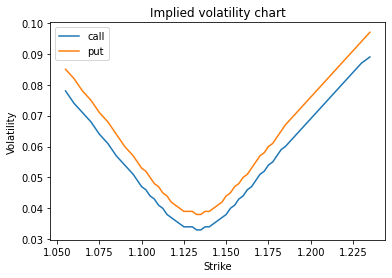

In [310]:
two_lines_plot(y1, y2, x, 
               "call", "put",
              "Implied volatility chart",
              "Strike",
              "Volatility")

# Implied volatility debugging cockpit

In [311]:
v = 0.035126268

In [312]:
eurusdcall = GarmanKolhagen(1.13370, 1.09, 365/365, 0.002, 0.0, v, 'call' )
p = eurusdcall.price
p

0.04817593450098856

In [313]:
vega = eurusdcall.vega
vega

0.22184793902009387

In [314]:
diff = abs(p-.0885)
diff

0.040324065499011436

In [315]:
try:
    float(vega)/float(diff)
except ZeroDivisionError:
    print(0)

In [316]:
adj = np.clip(diff/vega, -.01, .01)
adj

0.01

In [317]:
v = max(v-adj,0.001)
v

0.025126268

In [318]:
implied_volatility(0.0885, 1.1325, 1.05, 365/365, 0.015, 0.0, 'call')

0.04399999999999987